In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation

np.random.seed(1234)

In [99]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    device = torch.device("cpu")
    print("CPU")

# device = torch.device("cpu")

CUDA


In [ ]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [95]:
lbfgs_lr = 0.001
adam_lr = 0.001

w_pde = 1.0
w_bc = 1.0
w_ic = 1.0

In [110]:
class PINN():
    def __init__(self, x, t, int_vec, layers, f, ic1, ic2, train_cond='pde'):
        
        self.cond = train_cond

        self.x = x
        self.t = t

        self.int_d = int_vec[0]
        self.int_lbc = int_vec[1]
        self.int_rbc = int_vec[2]
        self.int_ic = int_vec[3]

        self.f = f
        self.ic1 = ic1
        self.ic2 = ic2

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=1000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, t):
        u = self.dnn(torch.cat((x, t), dim=1))
        return u
    
    def space_derivative(self, u, x):
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_3x = torch.autograd.grad(u_2x, x, torch.ones_like(u_2x), create_graph=True)[0]
        u_4x = torch.autograd.grad(u_3x, x, torch.ones_like(u_3x), create_graph=True)[0]      

        return u_x, u_2x, u_3x, u_4x
    
    def time_derivative(self, u , t):
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_2t = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]

        return u_t, u_2t

    def bc_loss(self, u, u_2x):
        bc_loss = torch.mean(u**2) + torch.mean(u_2x**2)
        return bc_loss
    
    def ic_loss(self, u, u_t):
        ic_loss = torch.mean((u - self.ic1)**2)
        ic_loss += torch.mean((u_t - self.ic2)**2)
        return ic_loss

    def pde_loss(self, u_4x, u_2t):        
        pde_loss = torch.mean((u_2t + u_4x - self.f)**2)
        return pde_loss

    def loss_func(self):
        u = self.model_value(self.x, self.t)
        _, u_2x, _, u_4x = self.space_derivative(u, self.x)
        u_t, u_2t = self.time_derivative(u, self.t)
        ic_loss = 0
        bc_loss = 0
        pde_loss = 0

        match self.cond:
            case 'ic':
                ic_loss += self.ic_loss(u[self.int_rbc:self.int_ic], u_t[self.int_rbc:self.int_ic])
            case 'bc':
                bc_loss += self.bc_loss(u[self.int_d:self.int_lbc], u_2x[self.int_d:self.int_lbc])
                bc_loss += self.bc_loss(u[self.int_lbc:self.int_rbc], u_2x[self.int_lbc:self.int_rbc])
            case 'pde':
                pde_loss += self.pde_loss(u_4x[:self.int_d], u_2t[:self.int_d])       
        return w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss


    def lbfgs_func(self):
        loss = self.loss_func()
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        return loss
    
    def train(self, epochs=1000):
        print(self.cond)
        self.dnn.train()
        for epoch in range(epochs):
            loss = self.loss_func()

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            # self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, t):
        x = torch.tensor(x).float().to(device)
        t = torch.tensor(t).float().to(device)

        self.dnn.eval()
        u = self.model_value(x, t)
        u = u.detach().cpu().numpy()
        return u

In [88]:
def func(x, t):
    return (1-16*np.pi**2) * np.sin(x) * np.cos(4*np.pi*t)

In [111]:
def generate_points(points):
    def ic_points(n_points):
        x = torch.rand(n_points, device=device) * torch.pi
        t = torch.zeros(n_points, device=device)
        return x, t

    def bc_points(n_points, x_bc):
        x = torch.ones(n_points, device=device) * x_bc
        t = torch.rand(n_points, device=device)
        return x, t

    def domain_points(n_points):
        x = torch.rand(n_points, device=device) * torch.pi
        t = torch.rand(n_points, device=device)
        return x, t

    x_d, t_d = domain_points(points[0])
    x_bc_lb, t_bc_lb = bc_points(points[1], 0)
    x_bc_rb, t_bc_rb = bc_points(points[1], torch.pi)
    x_ic, t_ic = ic_points(points[2])

    x_all = torch.cat([x_d, x_bc_lb, x_bc_rb, x_ic], dim=0).view(-1, 1)
    t_all = torch.cat([t_d, t_bc_lb, t_bc_rb, t_ic], dim=0).view(-1, 1)

    int1 = points[0]
    int2 = int1 + points[1]
    int3 = int2 + points[1]
    int4 = int3 + points[2]
    
    return x_all, t_all, [int1, int2, int3, int4]

In [91]:
points = [50, 2, 2]
x_t, t_t, int_vec = generate_points(points)
i1 = int_vec[0]
i2 = int_vec[1]
i3 = int_vec[2]
i4 = int_vec[3]

x_d = x_t[:i1]
t_d = t_t[:i1]
x_lbc = x_t[i1:i2]
x_rbc = x_t[i2:i3]
x_ic = x_t[i3:i4]

# print(x_d)
# print(x_lbc)
# print(x_rbc)
# print(x_ic)

u = torch.cat((x_d, t_d), 1)


In [112]:
points = [1000, 200, 200]
x_t, t_t, int_vec = generate_points(points)


x_ic = x_t[int_vec[2]:int_vec[3]]
x_d = x_t[:int_vec[0]]
t_d = t_t[:int_vec[0]]

f = lambda x, t: (1 - 16*torch.pi**2)*torch.sin(x)*torch.cos(4*torch.pi*t)
ic1 = lambda x: torch.sin(x)
ic2 = lambda x: torch.full_like(x, 0)

vec1 = ic1(x_ic)
vec2 = ic2(x_ic)
fun = f(x_d, t_d)

x_t = x_t.requires_grad_()
t_t = t_t.requires_grad_()


In [114]:
nodes = 20
layers = [2, nodes, nodes, nodes, nodes, nodes, nodes, 1]

model = PINN(x_t, t_t, int_vec, layers, fun, vec1, vec2)

In [122]:
model.cond = 'ic'
model.train(2000)

ic
Epoch 0, Loss: 1.254018e+01
Epoch 100, Loss: 8.704352e-01
Epoch 200, Loss: 4.443239e-01
Epoch 300, Loss: 2.444987e-01
Epoch 400, Loss: 1.552815e-01
Epoch 500, Loss: 1.170394e-01
Epoch 600, Loss: 1.008857e-01
Epoch 700, Loss: 9.382383e-02
Epoch 800, Loss: 9.041508e-02
Epoch 900, Loss: 8.851107e-02
Epoch 1000, Loss: 8.728621e-02
Epoch 1100, Loss: 8.641539e-02
Epoch 1200, Loss: 8.575708e-02
Epoch 1300, Loss: 8.524016e-02
Epoch 1400, Loss: 8.482382e-02
Epoch 1500, Loss: 8.448200e-02
Epoch 1600, Loss: 8.419690e-02
Epoch 1700, Loss: 8.395598e-02
Epoch 1800, Loss: 8.374994e-02
Epoch 1900, Loss: 8.357216e-02


In [124]:
model.cond = 'bc'
model.train(500)

bc
Epoch 0, Loss: 3.740824e+00
Epoch 100, Loss: 5.467133e-01
Epoch 200, Loss: 3.403365e-01
Epoch 300, Loss: 2.604540e-01
Epoch 400, Loss: 2.087559e-01


In [115]:
model.cond = 'pde'
model.train(5000)

pde
Epoch 0, Loss: 6.368843e+03
Epoch 100, Loss: 4.423844e+03
Epoch 200, Loss: 3.204351e+03
Epoch 300, Loss: 1.837361e+03
Epoch 400, Loss: 1.456645e+03
Epoch 500, Loss: 1.286898e+03
Epoch 600, Loss: 1.071286e+03
Epoch 700, Loss: 1.021433e+03
Epoch 800, Loss: 1.006368e+03
Epoch 900, Loss: 9.965272e+02
Epoch 1000, Loss: 9.320145e+02
Epoch 1100, Loss: 2.096839e+02
Epoch 1200, Loss: 1.090072e+02
Epoch 1300, Loss: 8.071232e+01
Epoch 1400, Loss: 6.922693e+01
Epoch 1500, Loss: 5.955059e+01
Epoch 1600, Loss: 5.270055e+01
Epoch 1700, Loss: 4.615800e+01
Epoch 1800, Loss: 3.258523e+01
Epoch 1900, Loss: 1.699298e+01
Epoch 2000, Loss: 1.299477e+01
Epoch 2100, Loss: 1.103170e+01
Epoch 2200, Loss: 9.668032e+00
Epoch 2300, Loss: 8.633563e+00
Epoch 2400, Loss: 7.820493e+00
Epoch 2500, Loss: 7.131932e+00
Epoch 2600, Loss: 1.406347e+01
Epoch 2700, Loss: 6.039843e+00
Epoch 2800, Loss: 5.591955e+00
Epoch 2900, Loss: 6.350488e+00
Epoch 3000, Loss: 4.855015e+00
Epoch 3100, Loss: 4.538695e+00
Epoch 3200, Loss

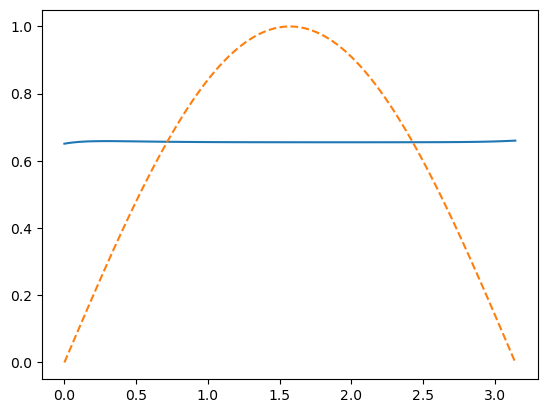

In [123]:

x = np.linspace(0, torch.pi, 100).reshape(-1, 1)
t = np.zeros(100).reshape(-1, 1)

y = np.sin(x)

u = model.predict(x, t)
plt.plot(x, u, label="PINN Solution")
plt.plot(x, y, label="Exact Solution", linestyle="dashed")

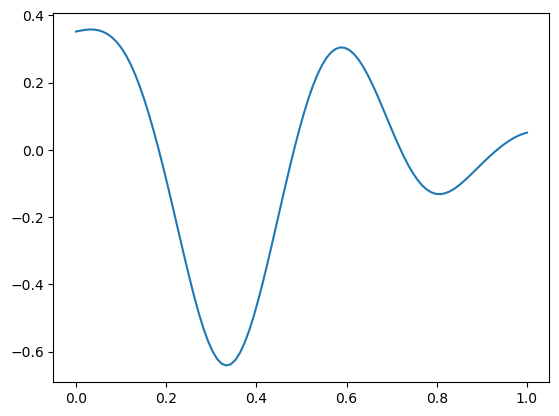

In [129]:
x_bc = np.ones(100).reshape(-1,1) * np.pi
t_bc = np.linspace(0, 1, 100).reshape(-1, 1)
u_bc = model.predict(x_bc, t_bc)
plt.plot(t_bc, u_bc)

In [ ]:

# Exact solution

def exact_solution(x, t):
    return np.sin(x)*np.cos(4*np.pi*t)


x = np.linspace(0, np.pi, 100)
t = np.linspace(0, 1, 100)

X, T = np.meshgrid(x, t)
U = np.sin(X) * np.cos(4 * np.pi * T) 

plt.imshow(U)
plt.colorbar()
plt.show()

# # Set up the figure and axis
# fig, ax = plt.subplots()
# ax.set_xlim(0, np.pi)
# ax.set_ylim(-1, 1)
# ax.set_xlabel("x")
# ax.set_ylabel("u(x, t)")
# ax.set_title("Animation of Exact Solution")


# # Initialize the line object
# line, = ax.plot([], [], lw=2)

# # Initialization function: Clears the line data
# def init():
#     line.set_data([], [])
#     return line,

# # Update function for each frame
# def update(frame):
#     y = exact_solution(x, t[frame])  # Compute solution at current time step
#     line.set_data(x, y)
#     return line,

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(t), init_func=init, blit=True, interval=50)

# ani.save("wave_animation.gif", writer="pillow", fps=30)

In [ ]:


X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
           

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

print(X_star)
print(lb)
print(ub)

[[0.        ]
 [0.03173326]
 [0.06346652]
 ...
 [3.07812614]
 [3.10985939]
 [3.14159265]]
241.00530565991463
[[1.47992659 1.50083637 1.52162576 ... 1.06179535 1.05856061 1.05526376]
 [1.44819865 1.46910844 1.48989782 ... 1.09352329 1.09028854 1.08699169]
 [1.41650267 1.43741245 1.45820184 ... 1.12521927 1.12198453 1.11868768]
 ...
 [1.41650267 1.43741245 1.45820184 ... 1.12521927 1.12198453 1.11868768]
 [1.44819865 1.46910844 1.48989782 ... 1.09352329 1.09028854 1.08699169]
 [1.47992659 1.50083637 1.52162576 ... 1.06179535 1.05856061 1.05526376]]


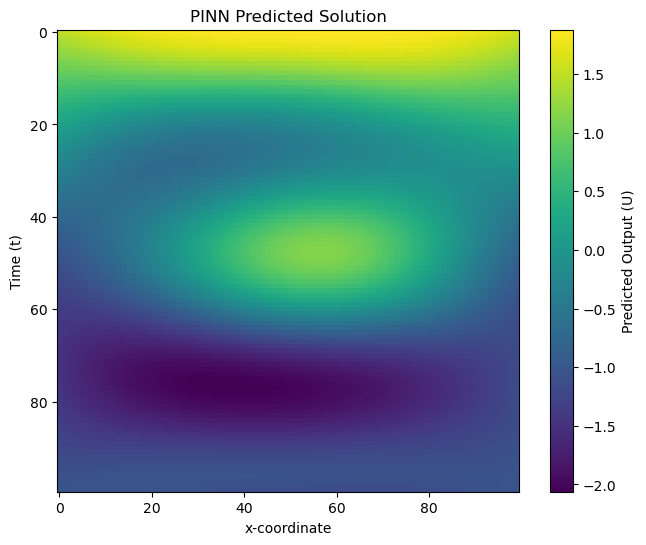

In [121]:
# Define the resolution of the grid
x_min, x_max = 0, np.pi  # X range
t_min, t_max = 0, 1  # Time range
grid_size = 100  # Number of points in each dimension

# Create a meshgrid
x_vals = np.linspace(x_min, x_max, grid_size)
t_vals = np.linspace(t_min, t_max, grid_size)
X, T = np.meshgrid(x_vals, t_vals)  # Create a 2D meshgrid

# Flatten the meshgrid and convert to PyTorch tensor
X_flat = X.flatten().reshape(-1, 1)
T_flat = T.flatten().reshape(-1, 1)
print(X_flat)

u_exact = np.sin(X_flat) * np.cos(4 * np.pi * T_flat)
u_pred = model.predict(X_flat, T_flat).flatten()
abs_error = np.abs(u_pred - u_exact)
l2_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact, 2)


# Reshape predictions back into a 2D grid
U_pred_reshaped = u_pred.reshape(grid_size, grid_size)

print(l2_error)
print(abs_error)

# Plot the result
plt.figure(figsize=(8, 6))
plt.imshow(U_pred_reshaped)
plt.colorbar(label="Predicted Output (U)")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Predicted Solution")
plt.show()